# Community detection using fast low-cardinality semidefinite programming
Welcome! This is the Colab for our [SDP community detection paper](https://arxiv.org/abs/2012.02676) in NeurIPS'20.

In this tutorial, we will demonstrate how to use the sdp_clustering package.
## Installation
The following command will download the code repository and compile it.

In [1]:
%%capture
!rm -rf sdp_clustering
!git clone --recursive https://github.com/locuslab/sdp_clustering sdp_clustering
!cd sdp_clustering && python setup.py develop

In [2]:
cd sdp_clustering/

/content/sdp_clustering


## Demonstration: Zachary Karate club
In the following session, we will demo the package by showing results for the famous example from Zachary Karate Club.

First, we load the graph and plot it.

In [3]:
data = 'data/zachary.mtx'

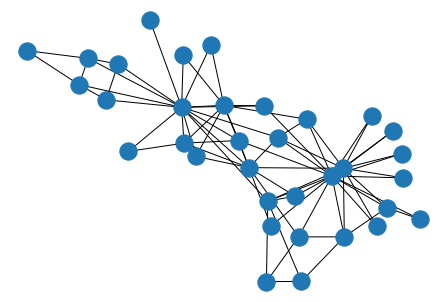

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.io import mmread
graph = mmread(data)
gx = nx.convert_matrix.from_numpy_matrix(graph.todense())
nx.draw(gx)

### Community detection
The goal of **community detection** is to find the hidden community / clusters inside a network. That is, it is a clustering problem with unknown number of clusters.

One way to solve the community detection problem by maximizing a metric function called **modularity**, which can be defined as

$Q(c):=\frac{1}{2m}\sum_{ij} \left[a_{ij}-\frac{d_id_j}{2m}\right]\mathbb{1}(c_i=c_j),$

where $a_{ij}$ is the edge weight connecting nodes $i$ and $j$, 
$d_i=\sum_j a_{ij}$ is the degree for node $i$, $m=\sum_{ij}a_{ij}/2$ is the sum of edge weights,
and $c_i\in [r]$ is the community assignment for node $i$ among the $r$ possible communities. The higher the modularity, the more organized the community assignment. Thus, we can maximize the metric function to obtain a good community assignment. However, the maximization problem is NP-complete and highly.
Thus, we proposed a smooth semidefinite relaxation to approximate the problem.

### The locale relaxation
The core idea of the Locale relaxation is that we can transform a Kronecker delta into a dot product

$\mathbb{1}(c_i=c_j) = v_i^T v_j,\;\text{where }\; v_i\in\{e(1),e(2),\ldots\}$, and the set $\{e(t)\}$ are the standard basis. 

For example, if two nodes are in the same cluster, we can assign both of them as $e(1)$, so $\mathbb{1}(c_i=c_j) = e(1)^Te(1) = 1$, and zero otherwise. 

The new encoding is exact and is still NP-complete, but we can further relax the standard basis into a smooth and continuous set containing the basis.
![Alt text](https://raw.githubusercontent.com/locuslab/sdp_clustering/main/images/locale.png)
Further, we can control the cardinality / sparsity of the relaxation to control the smoothness of the relaxed problem.
We called the relaxation the **Lo**w-**ca**rdina**l**ity **e**mbedding, that is, the **Locale** relxation.

## The API
Here, we show the embedding obtained from the demo graph (*zachary.mtx*).
The embeddings are sparse and presented as

$\text{index}_1:\text{value}_1\;\;\;\;\text{index}_2:\text{value}_2 \ldots$ 

for the 34 nodes in the graph.

In [5]:
from sdp_clustering import init_random_seed, leiden_locale, locale_embedding

init_random_seed(1234)
# obtain the embedding
E = locale_embedding(graph, k=2, eps=1e-3, max_inner=10, verbose=0)
print(E)

(1) 2:0.86	7:0.52	
(2) 2:0.98	8:0.21	
(3) 8:0.84	2:0.54	
(4) 2:0.91	8:0.41	
(5) 7:1.00	6:0.10	
(6) 7:0.99	6:0.11	
(7) 7:0.99	6:0.11	
(8) 2:0.90	8:0.43	
(9) 9:0.99	8:0.13	
(10) 8:0.92	9:0.39	
(11) 7:0.99	6:0.10	
(12) 2:0.83	7:0.56	
(13) 2:0.98	8:0.18	
(14) 2:0.90	8:0.44	
(15) 9:0.88	10:0.48	
(16) 9:0.88	10:0.48	
(17) 7:0.99	6:0.14	
(18) 2:0.99	7:0.16	
(19) 9:0.88	10:0.48	
(20) 2:1.00	7:0.03	
(21) 9:0.88	10:0.48	
(22) 2:0.99	7:0.16	
(23) 9:0.88	10:0.48	
(24) 10:0.73	24:0.69	
(25) 24:0.83	32:0.55	
(26) 24:0.79	32:0.61	
(27) 10:0.79	9:0.62	
(28) 24:0.91	10:0.42	
(29) 32:0.84	8:0.54	
(30) 10:0.84	9:0.55	
(31) 9:0.99	10:0.13	
(32) 32:0.83	24:0.55	
(33) 9:0.89	10:0.46	
(34) 9:0.84	10:0.54	



We show that the embeddings captures the cluster structure by showing their covariance matrix. The optimal assignment of the demo graph has 4 clusters, 
so correspondingly the optimal covariance graph has 4 blocks. 

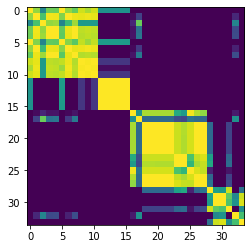

In [6]:
# obtain clustering result
labels = leiden_locale(graph)
# re-order the embedding
order = sorted(list(range(len(labels))), key=lambda x: labels[x])
V = E.to_scipy()[order]
# create the covariance matrix
C = (V@V.T).todense()
plt.imshow(C)

## Command line utilities
We can also use the command-line utilities **locale_alg** provided by the package to perform clustering and embedding. For example, to detect communities in Zachary Karate Club and output the result in labels.txt, run

In [7]:
!locale_alg {data} --out labels.txt --max_outer=3

iter 1(1)	opt fval 0.39981914	n_comm 5
iter 1(1)	rnd fval 0.21186720	n_comm 12
iter 1(2)	opt fval 0.41978961	n_comm 4
iter 1(2)	rnd fval 0.36875412	n_comm 5
iter 1(3)	opt fval 0.41978961	n_comm 4
iter 1(3)	rnd fval 0.41978961	n_comm 4
iter 1(4)	opt fval 0.41978961	n_comm 4
iter 1(4)	rnd fval 0.41978961	n_comm 4

iter 2(1)	opt fval 0.41978955	n_comm 4
iter 2(1)	rnd fval 0.23134451	n_comm 11
iter 2(2)	opt fval 0.41978961	n_comm 4
iter 2(2)	rnd fval 0.41978961	n_comm 4
iter 2(3)	opt fval 0.41978961	n_comm 4
iter 2(3)	rnd fval 0.41978961	n_comm 4

iter 3(1)	opt fval 0.41978961	n_comm 4
iter 3(1)	rnd fval 0.25969756	n_comm 10
iter 3(2)	opt fval 0.41978958	n_comm 4
iter 3(2)	rnd fval 0.41978961	n_comm 4
iter 3(3)	opt fval 0.41978961	n_comm 4
iter 3(3)	rnd fval 0.41978961	n_comm 4



The output shows the modularity (fval) and number of clusters (n_comm) for each hierarchical iterations. Note that opt means the modularity after relaxation, and rnd is the result after rounding. We can see that the final modularity is 0.4198, which is optimal.

To obtain embeddings, run

In [8]:
!locale_alg {data} --out emb.txt --embedding --verbose=0 --max_inner=10 --k=2
!cat emb.txt

2:0.8434904217720032	7:0.5371441841125488	
2:0.9853476881980896	8:0.1705576628446579	
8:0.7674331068992615	2:0.6411290764808655	
2:0.9597187042236328	8:0.2809625267982483	
7:0.9988347291946411	6:0.04826069995760918	
7:0.9983335137367249	6:0.05770694091916084	
7:0.9985255599021912	6:0.05428372323513031	
2:0.9383329749107361	8:0.34573298692703247	
9:0.955811619758606	10:0.2939799726009369	
8:0.9194113612174988	9:0.39329734444618225	
7:0.9986326098442078	6:0.05227864533662796	
2:0.8082109093666077	7:0.5888931751251221	
2:0.9845686554908752	7:0.1749989092350006	
2:0.9362026453018188	8:0.35146087408065796	
9:0.8369048833847046	10:0.5473482608795166	
9:0.8372026085853577	10:0.5468928813934326	
7:0.997382640838623	6:0.07230319827795029	
2:0.9853029847145081	7:0.17081592977046967	
9:0.8374990820884705	10:0.5464388132095337	
2:0.999264121055603	7:0.03835659846663475	
9:0.8377942442893982	10:0.5459861755371094	
2:0.9853131175041199	7:0.17075775563716888	
9:0.8380880355834961	10:0.545534908771514

That's all! For more details, please refer to our [paper](https://arxiv.org/abs/2012.02676) and [github repo](https://github.com/locuslab/sdp_clustering).